# **Used Car Price Prediction**

### **Problem Description**

The price of a used car is a critical factor in the automotive market, reflecting a vehicle's value based on its condition, history, features, and brand reputation. Predicting market prices accurately helps sellers set competitive rates, allows buyers to negotiate fair deals, and allows dealerships to manage their inventory.

The dataset was taken from Kaggle: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset.

The purpose of this project is to simulate the process of predicting the selling price of used cars using multiple ML regression techniques and comparing their performance on the analyzed data.


### **Data Description**

The dataset was sourced from Kaggle:

The dataset consists of the following columns:
* brand: The manufacturer of the car (e.g., Ford, Toyota).

* model: The specific model name (e.g., F-150, Camry).

* model_year: The manufacturing year of the vehicle.

* milage: The total distance driven by the car (in miles).

* fuel_type: The type of fuel used (e.g., Gasoline, Hybrid, Diesel).

* engine: Technical description of the engine (e.g., horsepower, displacement, cylinder count).

* transmission: The type of transmission (e.g., Automatic, CVT, Manual).

* ext_col: The exterior color of the car.

* int_col: The interior color of the car.

* accident: Reported accident history (e.g., "At least 1 accident or damage reported").

* clean_title: Indicator of whether the car has a clean title status.

* price: The listed selling price of the car (target variable).

## Import Dependencies

In [ ]:
!pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
#from adaboost import AdaBoostRegressor

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Data import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/used_cars.csv')

### Data cleaning

In [ ]:
# before cleaning
print(df[['price', 'milage']].head())

     price      milage
0  $10,300  51,000 mi.
1  $38,005  34,742 mi.
2  $54,598  22,372 mi.
3  $15,500  88,900 mi.
4  $34,999   9,835 mi.


In [ ]:
df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df['milage'] = df['milage'].astype(str)
df['milage'] = df['milage'].str.replace(' mi.', '')
df['milage'] = df['milage'].str.replace(',', '')
df['milage'] = pd.to_numeric(df['milage'], errors='coerce')

df['fuel_type'] = df['fuel_type'].fillna('Unknown')
df['accident'] = df['accident'].fillna('Unknown')
df['clean_title'] = df['clean_title'].fillna('Unknown')
df = df.dropna(subset=['price'])

In [ ]:
# after cleaning
print(df[['price', 'milage']].head())

   price  milage
0  10300   51000
1  38005   34742
2  54598   22372
3  15500   88900
4  34999    9835


### Feature Engineering

In [ ]:
# We need to get Horsepower from the Engine text
def get_horsepower(text):
    text = str(text)

    if 'HP' in text:
        match = re.search(r'(\d+\.?\d*)HP', text)
        if match:
            return float(match.group(1))

    return 0.0

In [ ]:
df['horsepower'] = df['engine'].apply(get_horsepower)

# if horsepower = 0, replace it with the median value
median_hp = df['horsepower'].median()
df['horsepower'] = df['horsepower'].replace(0.0, median_hp)

df[['engine', 'horsepower']].head()

,engine,horsepower
0,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,300.0
1,3.8L V6 24V GDI DOHC,285.0
2,3.5 Liter DOHC,285.0
3,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,354.0
4,2.0L I4 16V GDI DOHC Turbo,285.0


We decided to create "Luxury" flag to easier manipulate the data, because there were only 34 cars between 200k and 272k. By adding the "is_luxury" feature, we group these 34 cars with other semi-expensive ones, giving the model a stronger signal to "predict high" for this group.

In [ ]:
luxury_brands = ['Bugatti', 'Lamborghini', 'Rolls-Royce', 'Ferrari', 'McLaren',
                 'Aston', 'Bentley', 'Maybach', 'Porsche', 'Maserati',
                 'Lucid', 'Rivian', 'Karma']
df['is_luxury'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)

In [ ]:
# fill missing values in text columns
text_columns = ['brand', 'model', 'fuel_type', 'transmission',
                'ext_col', 'int_col', 'accident', 'clean_title', 'engine']

for col in text_columns:
    df[col] = df[col].fillna('Unknown')

## Exploratory Data Analysis (EDA)



In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         4009 non-null   object 
 1   model         4009 non-null   object 
 2   model_year    4009 non-null   int64  
 3   milage        4009 non-null   int64  
 4   fuel_type     4009 non-null   object 
 5   engine        4009 non-null   object 
 6   transmission  4009 non-null   object 
 7   ext_col       4009 non-null   object 
 8   int_col       4009 non-null   object 
 9   accident      4009 non-null   object 
 10  clean_title   4009 non-null   object 
 11  price         4009 non-null   int64  
 12  horsepower    4009 non-null   float64
 13  is_luxury     4009 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 438.6+ KB
None


In [ ]:
print(df.describe())

        model_year         milage         price   horsepower    is_luxury
count  4009.000000    4009.000000  4.009000e+03  4009.000000  4009.000000
mean   2015.515590   64717.551010  4.455319e+04   322.692193     0.088800
std       6.104816   52296.599459  7.871064e+04   110.871764     0.284491
min    1974.000000     100.000000  2.000000e+03    70.000000     0.000000
25%    2012.000000   23044.000000  1.720000e+04   268.000000     0.000000
50%    2017.000000   52775.000000  3.100000e+04   285.000000     0.000000
75%    2020.000000   94100.000000  4.999000e+04   381.000000     0.000000
max    2024.000000  405000.000000  2.954083e+06  1020.000000     1.000000


In [ ]:
print(df.isnull().sum())

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
horsepower      0
is_luxury       0
dtype: int64


Dataset Statistics
Total cars: 4009
Average Price: $ 44553.19
Median Price: $ 31000.0
Max Price: $ 2954083
Min Price: $ 2000


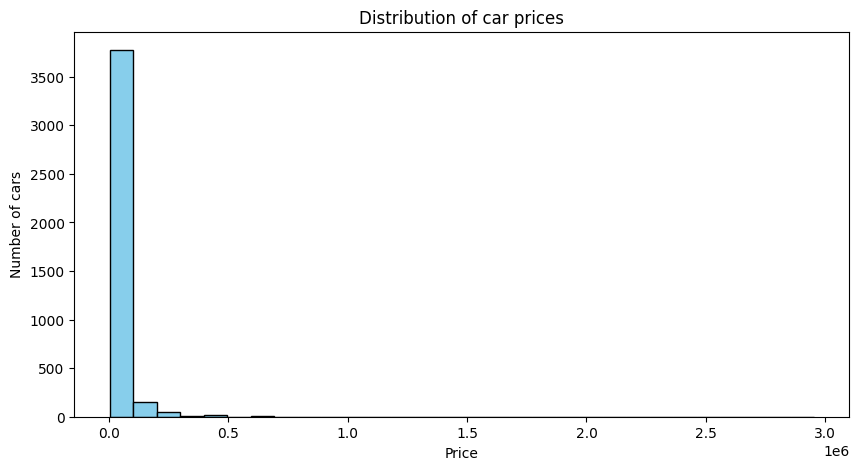

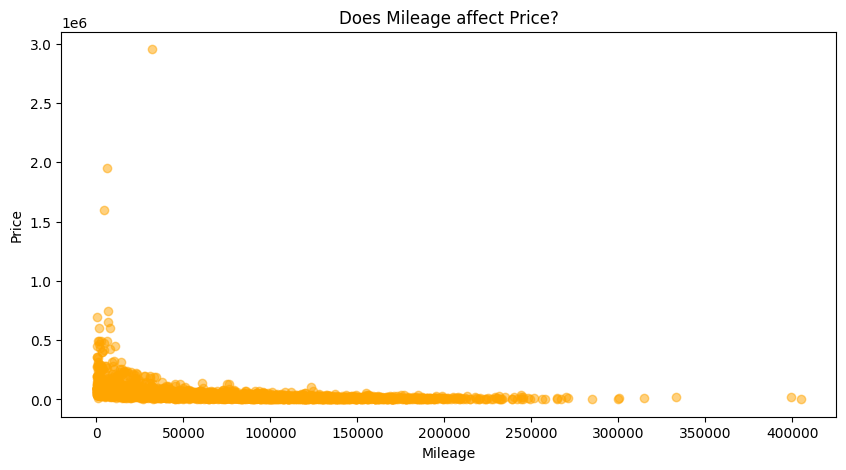

In [ ]:
print("Dataset Statistics")
print("Total cars:", len(df))
print("Average Price: $", round(df['price'].mean(), 2))
print("Median Price: $", round(df['price'].median(), 2))
print("Max Price: $", df['price'].max())
print("Min Price: $", df['price'].min())

plt.figure(figsize=(10, 5))
plt.hist(df['price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of car prices')
plt.xlabel('Price')
plt.ylabel('Number of cars')
plt.show()

# Price vs Mileage
plt.figure(figsize=(10, 5))
plt.scatter(df['milage'], df['price'], alpha=0.5, color='orange')
plt.title('Does Mileage affect Price?')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

As we see, most values are concentrated at one end + outliers as visible in Max value (2.9mln compared to the median 50% = 31,000). Let's apply Log Transformation to make the distribution more uniform (reduce skewness, make outliers less impactful and cap them).

#### Capping outliers

In [ ]:
print("Original data shape:", df.shape)

# We remove the top 1% of most expensive cars to stabilize the model
price_limit = df['price'].quantile(0.99)
mileage_limit = df['milage'].quantile(0.99)

print(f"Capping prices above: {price_limit:,.0f}")
print(f"Capping mileage above: {mileage_limit:,.0f}")

df = df[(df['price'] < price_limit) & (df['milage'] < mileage_limit)]
print("Data shape after capping:", df.shape)

Original data shape: (4009, 14)
Capping prices above: 272,713
Capping mileage above: 222,428
Data shape after capping: (3927, 14)


#### Log Transformation

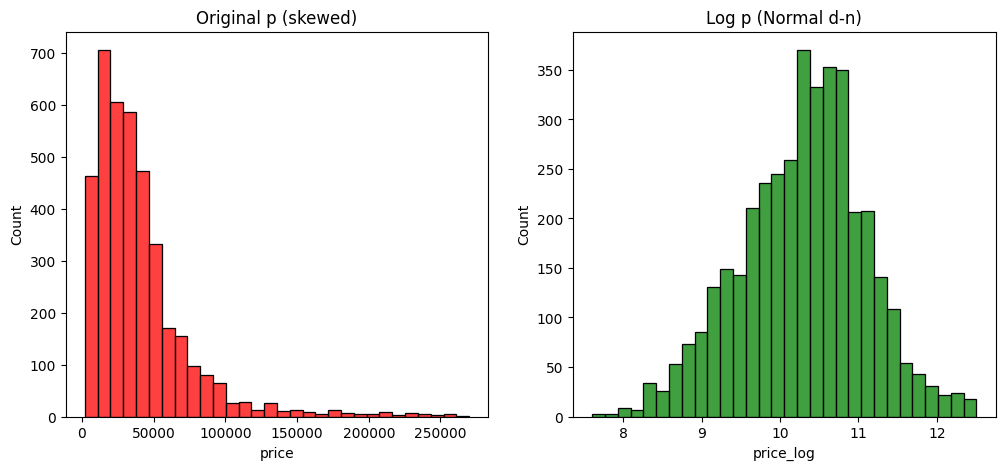

In [ ]:
df['price_log'] = np.log1p(df['price'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=30, color='red')
plt.title('Original p (skewed)')

plt.subplot(1, 2, 2)
sns.histplot(df['price_log'], bins=30, color='green')
plt.title('Log p (Normal d-n)')
plt.show()

#### Analyze the patterns

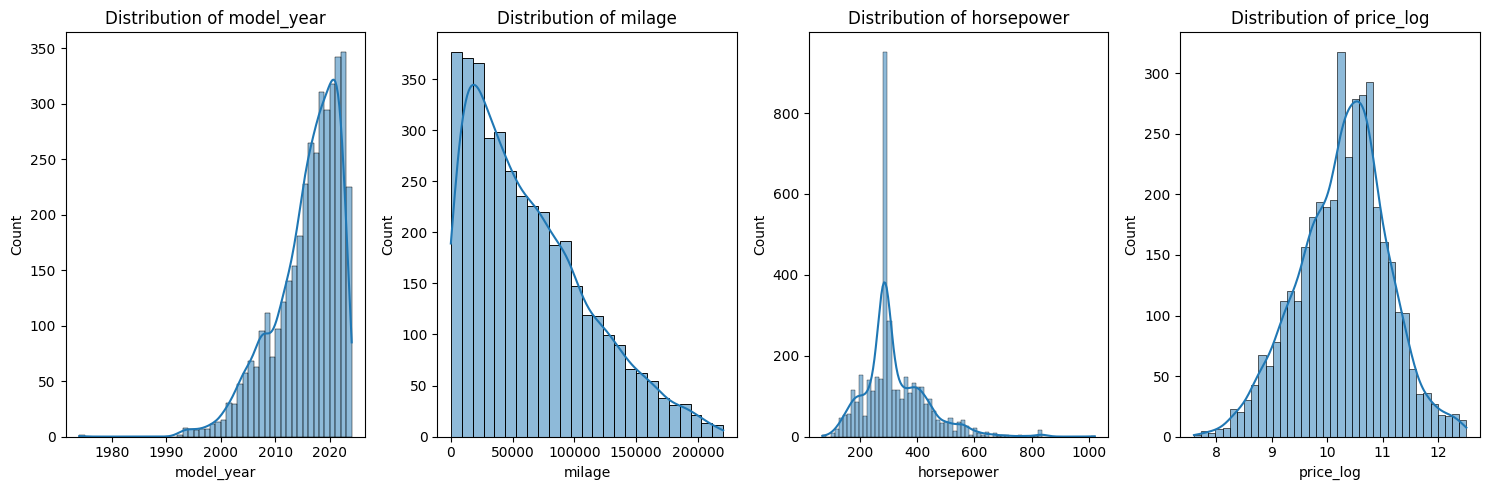

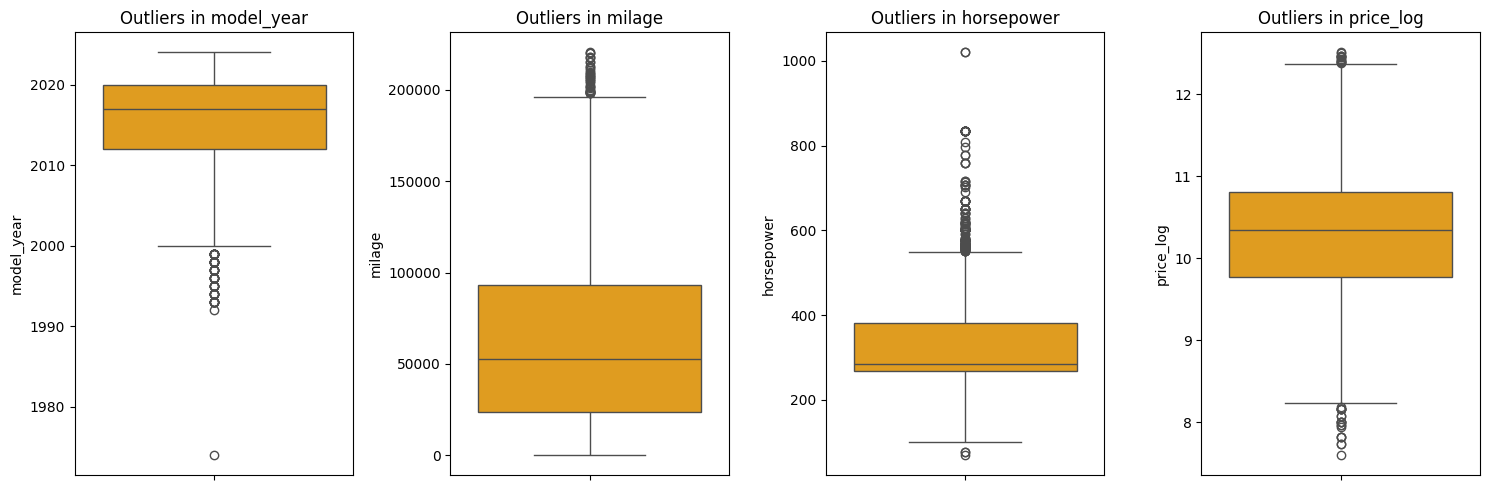

In [ ]:
numeric_cols = ['model_year', 'milage', 'horsepower', 'price_log']

plt.figure(figsize=(15, 5))
for i, column in enumerate(numeric_cols):
    plt.subplot(1, 4, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, column in enumerate(numeric_cols):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[column], color='orange')
    plt.title(f'Outliers in {column}')
plt.tight_layout()
plt.show()

The visual analysis confirms that our Capping + Log Transformation successfully normalized our Target variable. Even though like Mileage and Year have their natural skewness, the outliers are now placed to a range that will not destabilize further models.

#### Train-Test Split

In [ ]:
X = df.drop(columns=['price', 'price_log'])
y = df['price_log']

# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (3141, 13)
Testing shape: (786, 13)


## Modelling

#### CatBoost

In [ ]:
categorical_features = ['brand', 'model', 'fuel_type', 'transmission',
                        'ext_col', 'int_col', 'accident', 'clean_title', 'engine']
model_cat = CatBoostRegressor(
    cat_features=categorical_features,
    iterations=5000,
    early_stopping_rounds=50, # safety switch
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=500,
    random_seed=42
)
model_cat.fit(
    X_train, y_train,
    eval_set=(X_test, y_test)
)

0:	learn: 0.7681252	test: 0.7887441	best: 0.7887441 (0)	total: 86.9ms	remaining: 7m 14s
500:	learn: 0.2298168	test: 0.2856044	best: 0.2856044 (500)	total: 15.1s	remaining: 2m 15s
1000:	learn: 0.1849516	test: 0.2753615	best: 0.2753330 (998)	total: 24.7s	remaining: 1m 38s
1500:	learn: 0.1574224	test: 0.2721652	best: 0.2720455 (1473)	total: 30s	remaining: 1m 9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2720454892
bestIteration = 1473

Shrink model to first 1474 iterations.


RMSE in $: 14,753.38
R2 Score: 0.8267


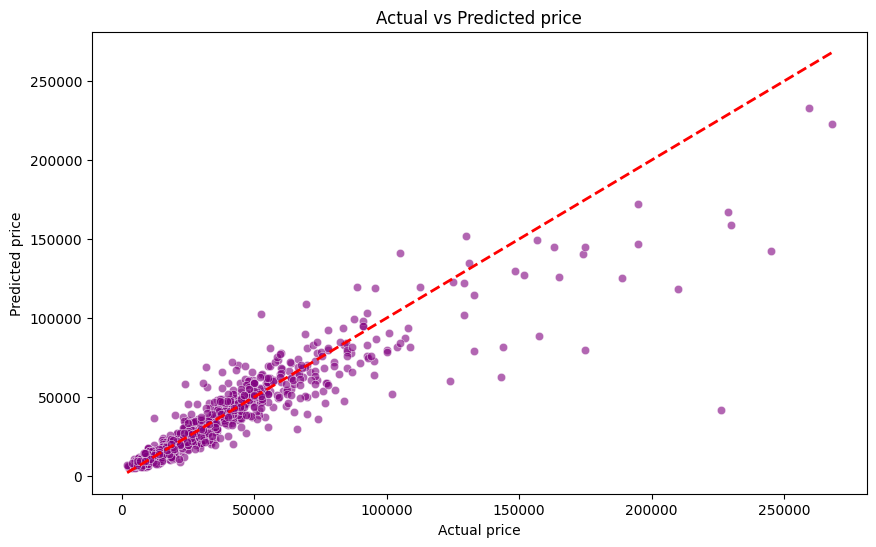

In [ ]:
# make predictions
y_pred_log = model_cat.predict(X_test)

# reverse the log transformation to get actual dollar values
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

rmse_cat = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_cat = r2_score(y_test_actual, y_pred_actual)

print(f"RMSE in $: {rmse_cat:,.2f}")
print(f"R2 Score: {r2_cat:.4f}")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6, color='purple')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs Predicted price')
plt.show()

It seems like we have a model that understands the market very well, but it is likely struggling with the extreme high-price (luxurious) cars. Additional Luxury variable did not significantly improve the situation.

XGBoost

In [ ]:
model_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    enable_categorical=True
)

In [ ]:
X_enc = pd.get_dummies(df[categorical_features])




In [ ]:
X_num = df.drop(columns=categorical_features)
X_xgb = pd.concat([X_num,X_enc],axis=1)
X_xgb = X_xgb.drop(columns=['price', 'price_log'])
X_xgb.head()

model_year  milage  horsepower  is_luxury  brand_Acura  brand_Alfa  \
0        2013   51000       300.0          0        False       False   
1        2021   34742       285.0          0        False       False   
2        2022   22372       285.0          0        False       False   
3        2015   88900       354.0          0        False       False   
4        2021    9835       285.0          0        False       False   

   brand_Aston  brand_Audi  brand_BMW  brand_Bentley  brand_Buick  \
0        False       False      False          False        False   
1        False       False      False          False        False   
2        False       False      False          False        False   
3        False       False      False          False        False   
4        False        True      False          False        False   

   brand_Cadillac  brand_Chevrolet  brand_Chrysler  brand_Dodge  brand_FIAT  \
0           False            False           False        False       False   
1           False            False           False        False       False   
2           False            False           False        False       False   
3           False            False           False        False       False   
4           False            False           False        False       False   

   brand_Ferrari  brand_Ford  brand_GMC  brand_Genesis  brand_Honda  \
0          False        True      False          False        False   
1          False       False      False          False        False   
2          False       False      False          False        False   
3          False       False      False          False        False   
4          False       False      False          False        False   

   brand_Hummer  brand_Hyundai  brand_INFINITI  brand_Jaguar  brand_Jeep  \
0         False          False           False         False       False   
1         False           True           False         False       False   
2         False          False           False         False       False   
3         False          False            True         False       False   
4         False          False           False         False       False   

   brand_Karma  brand_Kia  brand_Lamborghini  brand_Land  brand_Lexus  \
0        False      False              False       False        False   
1        False      False              False       False        False   
2        False      False              False       False         True   
3        False      False              False       False        False   
4        False      False              False       False        False   

   brand_Lincoln  brand_Lotus  brand_Lucid  brand_MINI  brand_Maserati  \
0          False        False        False       False           False   
1          False        False        False       False           False   
2          False        False        False       False           False   
3          False        False        False       False           False   
4          False        False        False       False           False   

   brand_Maybach  brand_Mazda  brand_McLaren  brand_Mercedes-Benz  \
0          False        False          False                False   
1          False        False          False                False   
2          False        False          False                False   
3          False        False          False                False   
4          False        False          False                False   

   brand_Mercury  brand_Mitsubishi  brand_Nissan  brand_Plymouth  \
0          False             False         False           False   
1          False             False         False           False   
2          False             False         False           False   
3          False             False         False           False   
4          False             False         False           False   

   brand_Polestar  brand_Pontiac  brand_Porsche  brand_RAM  brand_Rivian  \
0     

In [ ]:
# 80% for training, 20% for testing
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_xgb_train.shape}")
print(f"Testing shape: {X_xgb_test.shape}")

Training shape: (3141, 3563)
Testing shape: (786, 3563)


In [ ]:

model_xgb.fit(
    X_xgb_train, y_xgb_train,
    eval_set=[(X_xgb_test, y_xgb_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

RMSE in $: 15,315.51
R2 Score: 0.8133


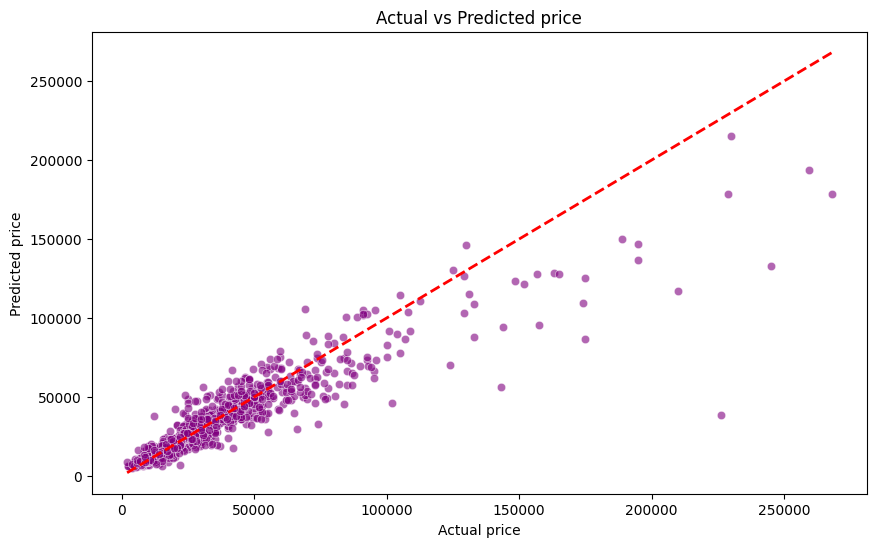

In [ ]:
#make predictions
y_pred_log = model_xgb.predict(X_xgb_test)

# reverse the log transformation to get actual dollar values
y_test_actual = np.expm1(y_xgb_test)
y_pred_actual = np.expm1(y_pred_log)

rmse_xgb = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_xgb = r2_score(y_test_actual, y_pred_actual)

print(f"RMSE in $: {rmse_xgb:,.2f}")
print(f"R2 Score: {r2_xgb:.4f}")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6, color='purple')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs Predicted price')
plt.show()

The outcome is pretty similar - the model underpredicts the value of ultra-luxury cars, indicating that the difficulty in capturing such car prices is likely a data limitation rather than an algorithm issue.

AdaBoost

In [ ]:
base_estimator = DecisionTreeRegressor(
    max_depth=3,
    random_state=42
)

In [ ]:
adaboost = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=200,
    learning_rate=0.05,
    loss='square',
    random_state=42
)

In [ ]:
adaboost.fit(
    X_xgb_train, y_xgb_train,
)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3, random_state=42),
                  learning_rate=0.05, loss='square', n_estimators=200,
                  random_state=42)

RMSE in $: 23,045.11
R2 Score: 0.5772


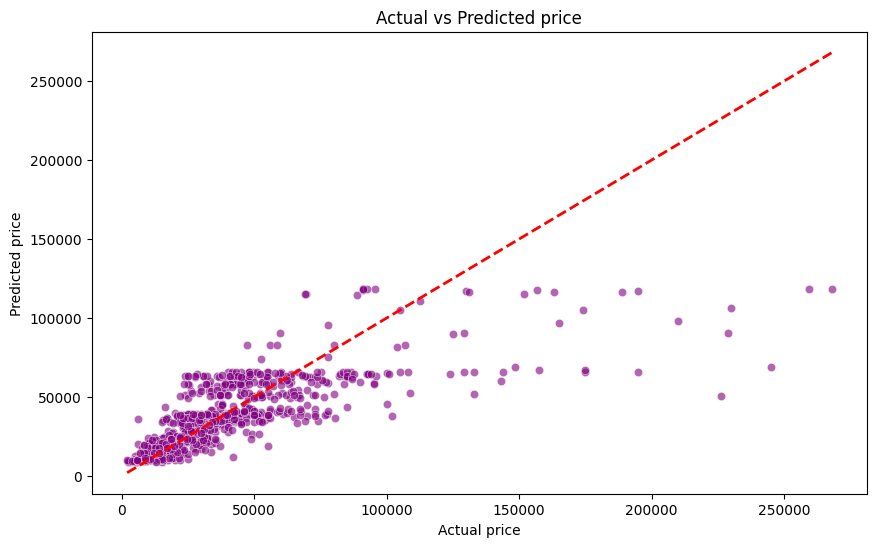

In [ ]:
#make predictions
y_pred_log = adaboost.predict(X_xgb_test)

# reverse the log transformation to get actual dollar values
y_test_actual = np.expm1(y_xgb_test)
y_pred_actual = np.expm1(y_pred_log)

rmse_ada = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_ada = r2_score(y_test_actual, y_pred_actual)

print(f"RMSE in $: {rmse_ada:,.2f}")
print(f"R2 Score: {r2_ada:.4f}")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6, color='purple')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', lw=2)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs Predicted price')
plt.show()

This model shows a significant decline in performance, indicating it is underfitting the data. Visually, there is a clear 'ceiling' - the model fails to predict prices above ~$125k, causing the predictions to stay horizontal even as actual prices increase. This suggests the model lacks the data complexity to differentiate between luxury cars and simple ones.

#Final remarks and conclusions




In [ ]:
y_true = np.expm1(y_test)

models_to_test = {
    'CatBoost': (model_cat, X_test),
    'XGBoost':  (model_xgb, X_xgb_test),
    'AdaBoost': (adaboost, X_xgb_test)
}

results = {}

print("Model Comparison \n")

for name, (model, data) in models_to_test.items():
    pred_log = model.predict(data)
    pred_dollar = np.expm1(pred_log)

    pred_dollar = np.clip(pred_dollar, 0, None)

    r2 = r2_score(y_true, pred_dollar)
    rmse = np.sqrt(mean_squared_error(y_true, pred_dollar))

    results[name] = {'R^2': r2, 'RMSE': rmse}

    print(f"{name:} | R^2: {r2:.4f} | RMSE: ${rmse:,.2f}")

names = list(results.keys())
r2_scores = [results[n]['R^2'] for n in names]
rmse_scores = [results[n]['RMSE'] for n in names]

Model Comparison 

CatBoost | R^2: 0.8267 | RMSE: $14,753.38
XGBoost | R^2: 0.8133 | RMSE: $15,315.51
AdaBoost | R^2: 0.5772 | RMSE: $23,045.11


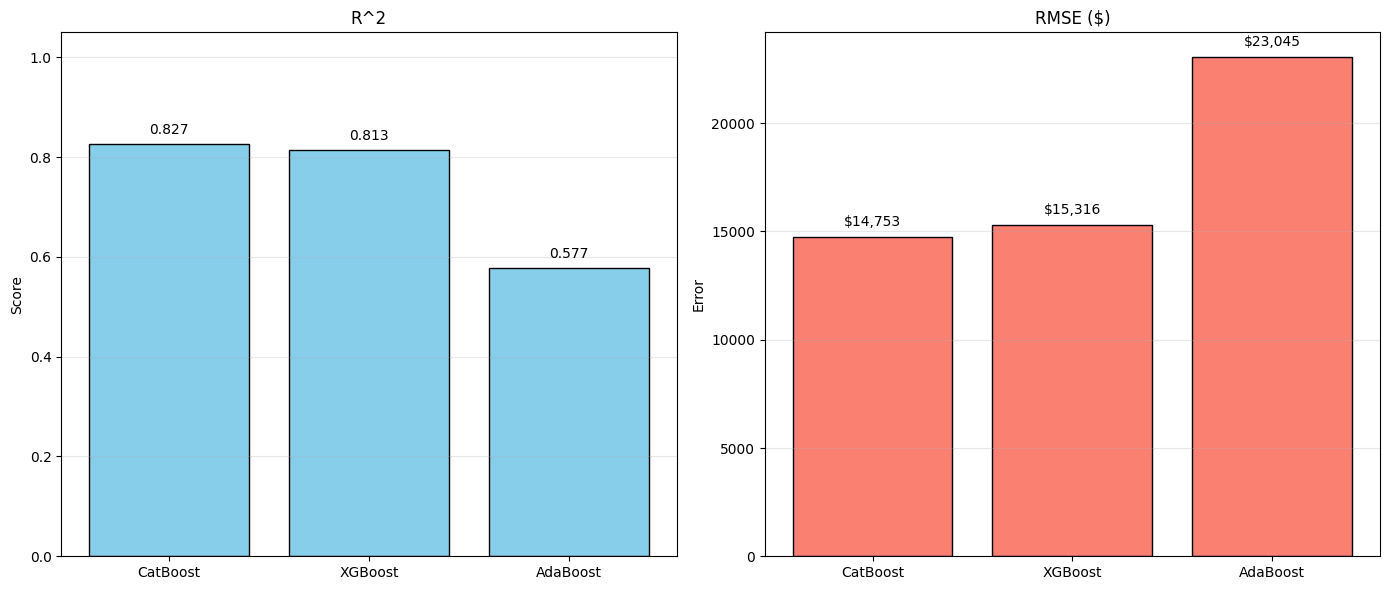

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(names, r2_scores, color='skyblue', edgecolor='black')
plt.title('R^2')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.3)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', ha='center')

plt.subplot(1, 2, 2)
bars = plt.bar(names, rmse_scores, color='salmon', edgecolor='black')
plt.title('RMSE ($)')
plt.ylabel('Error')
plt.grid(axis='y', alpha=0.3)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f'${yval:,.0f}', ha='center')

plt.tight_layout()
plt.show()

# Final Comment

After testing several regression models, we found that CatBoost showed the best performance, achieving the highest R^2 and the lowest RMSE. Its ability to handle categorical features (like Brand, Model, and Color) made it quite effective at capturing the prices of all used cars.

XGBoost also performed very strongly, showing results comparable to CatBoost. However, CatBoost proofed itself better in capturing that "long tail" of rare cars.

AdaBoost, while effective, didn't quite match the accuracy of the other two models. This is likely because AdaBoost relies on simple 'weak learners'. In this case, those base models didn't have the complexity for luxury market, resulting in significant underfitting and a visible 'ceiling' on price predictions.

In conclusion, CatBoost proved to be the most reliable and accurate model for predicting used car prices in this analysis with the best balance between precision and resilience to outliers.